# Set up calibration

In [1]:
import lzma
from collections import OrderedDict
from pathlib import Path

import numpy as np
import corner
import dill as pickle
from matplotlib import pyplot as plt
from scipy import stats
from scipy.optimize import minimize
from tqdm import tqdm

In [2]:
import emcee

In [3]:
import rxmc

Using database version X4-2024-12-31 located in: /mnt/home/beyerkyl/x4db/unpack_exfor-2024/X4-2024-12-31


In [4]:
rxmc.__version__

'0.1.dev207+ga0ea96b28.d20250826'

In [5]:
rng = np.random.default_rng(49)

## make the model

In [6]:
from linear_model import LinearModel

In [7]:
my_model = LinearModel()

In [8]:
prior_mean = OrderedDict(
    [
        ("m", 1),
        ("b", 1),
    ]
)
prior_std_dev = OrderedDict(
    [
        ("m", 1),
        ("b", 1),
    ]
)

In [9]:
covariance = np.diag(list(prior_std_dev.values())) ** 2
mean = np.array(list(prior_mean.values()))

In [10]:
n_prior_samples = 1000
prior_distribution = stats.multivariate_normal(mean, covariance)
prior_samples = prior_distribution.rvs(size=n_prior_samples, random_state=rng)

Text(0.5, 0.98, 'prior')

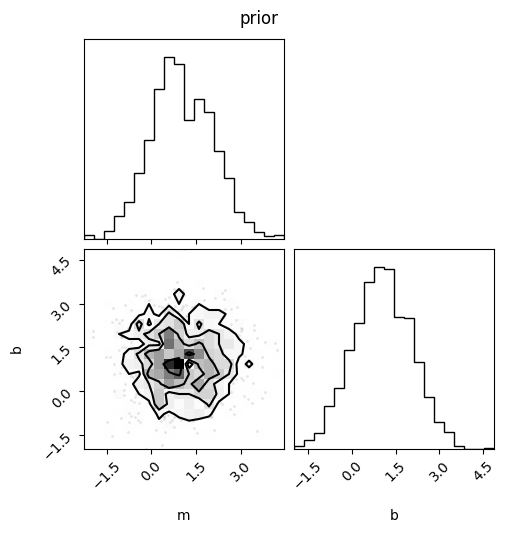

In [11]:
fig = corner.corner(prior_samples, labels=[p.name for p in my_model.params])
fig.suptitle("prior")

In [12]:
true_params = OrderedDict(
    [
        ("m", 0.6),
        ("b", 2),
    ]
)

x = rng.random(20)
noise = 0.05
y_exp = my_model.y(x, *list(true_params.values())) + rng.normal(
    scale=noise, size=len(x)
)
y_stat_err = noise * np.ones_like(y_exp)  # noise is just a constant fraction of y
obs1 = rxmc.observation.Observation(x=x, y=y_exp, y_stat_err=y_stat_err)

Text(0.5, 1.0, 'experimental constraint')

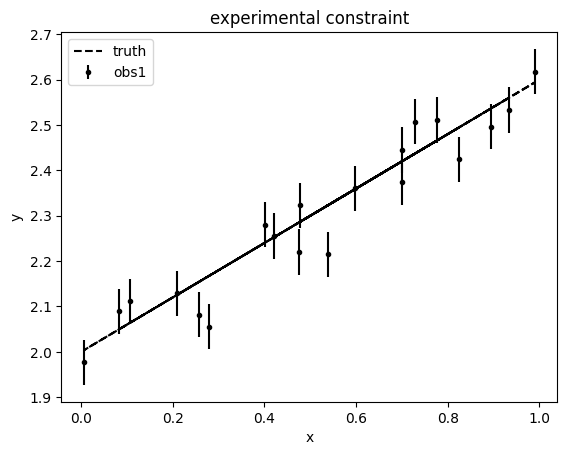

In [13]:
plt.errorbar(
    x,
    y_exp,
    y_stat_err,
    color="k",
    marker=".",
    linestyle="none",
    label="obs1",
)
plt.plot(x, my_model.y(x, *list(true_params.values())), "k--", label="truth")
plt.xlabel("x")
plt.ylabel("y")

plt.legend()
plt.title("experimental constraint")

In [14]:
likelihood_model = rxmc.likelihood_model.LikelihoodModel()

In [15]:
constraint = rxmc.constraint.Constraint(
    [obs1],
    my_model,
    likelihood_model,
)

In [16]:
evidence = rxmc.evidence.Evidence([constraint])

In [17]:
pconf = rxmc.config.ParameterConfig(
    params=my_model.params,
    prior=prior_distribution,
    initial_proposal_distribution=stats.multivariate_normal(
        mean=prior_distribution.mean, cov=prior_distribution.cov / 100
    ),
)

In [18]:
cal_conf = rxmc.config.CalibrationConfig(evidence=evidence, model_config=pconf)

In [19]:
with open("./calibration_config.pkl", "wb") as f:
    pickle.dump(cal_conf, f)

## Test emcee run

In [20]:
n_walkers = 64
n_walkers

64

In [21]:
moves = emcee.moves.DEMove()
sampler = emcee.EnsembleSampler(
    nwalkers=n_walkers,
    ndim=len(my_model.params),
    log_prob_fn=cal_conf.log_posterior,
    moves=moves,
)

In [22]:
x0 = stats.multivariate_normal(
    mean=prior_distribution.mean, cov=prior_distribution.cov /100
).rvs(n_walkers)

In [23]:
state = sampler.run_mcmc(x0, 10000, progress=True)

100%|██████████| 10000/10000 [01:23<00:00, 120.40it/s]


In [24]:
m = np.mean(sampler.chain[:, :, :], axis=(0, 1))
s = np.std(sampler.chain[:, :, :], axis=(0, 1))

In [25]:
m

array([0.60373975, 1.9857784 ])

In [26]:
s

array([0.04882442, 0.03439742])

In [27]:
x_full = np.linspace(-1,2,100)

In [28]:
posterior_samples = sampler.get_chain(flat=True, thin=100)
y = np.zeros((posterior_samples.shape[0], len(x_full)))

for i in range(posterior_samples.shape[0]):
    sample = posterior_samples[i]
    y[i, :] = my_model.y(x_full, *sample)

upper, median, lower = np.percentile(y, [5, 50, 95], axis=0)

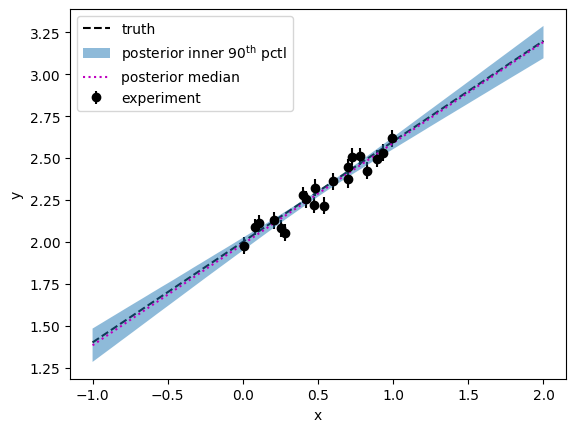

In [29]:
plt.plot(x_full, my_model.y(x_full, *list(true_params.values())), "k--", label="truth")
plt.xlabel("x")
plt.ylabel("y")
plt.errorbar(
    x,
    obs1.y,
    y_stat_err,
    color="k",
    marker="o",
    linestyle="none",
    label="experiment",
)
plt.fill_between(
    x_full,
    lower,
    upper,
    alpha=0.5,
    zorder=2,
    label=r"posterior inner 90$^\text{th}$ pctl",
)
plt.plot(x_full, median, "m:", label="posterior median")

plt.legend()
# plt.title("predictive posterior")